# *Visualizing SLaPkNN with M<N Prototypes*
1. Run the first cell to start the visualization.
2. Use the 'Mode' dropdown to choose a method of positioning prototypes. 
3. Use num_points and num_classes to control M and N, respectively.
4. Setting a higher resolution improves accuracy but may slow down computation.
5. To save the image, first type desired filename in the provided blank, then press the save button.

<IPython.core.display.Javascript object>


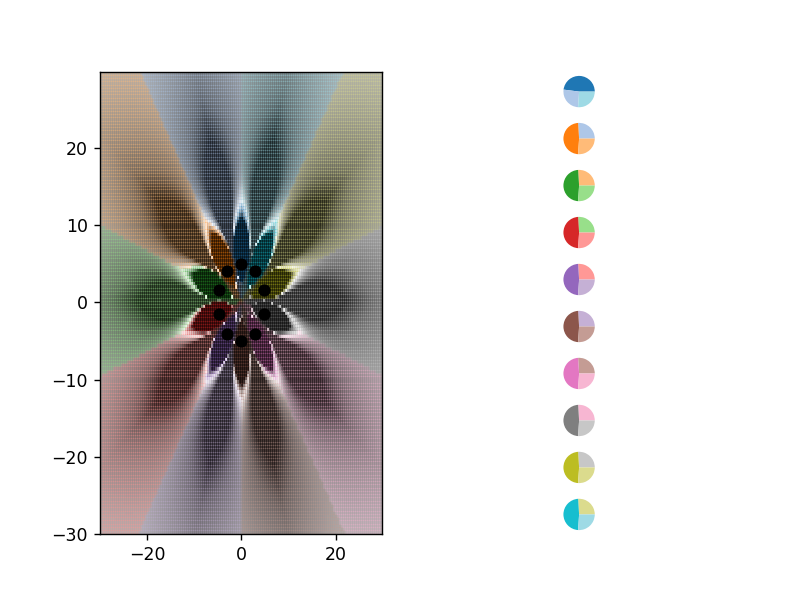

Button(description='Save image', style=ButtonStyle())

Output()

interactive(children=(IntSlider(value=10, continuous_update=False, description='frame', max=60, min=-60, step=…

In [92]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from soft_knn import SoftKNN, softmax
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import fractions
import itertools
from collections import Counter


def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
def create_system(n, verbose=False):
    A=[]
    for i in range(1,int(np.ceil(n/2.))):
        for j in range(2*i, n):#int(np.floor(n/2.))+i
            vector = np.zeros(n)
            vector[i-1]+=(1./(j/2.))
            vector[n-i+1-1]+=(1/(n-(j/2.)))
            vector[j-i+1-1]+=(-1./(j/2.))
            vector[n-j+i-1]+=(-1/(n-(j/2.)))
            A.append(vector)
            if verbose:
                print ("(y_{0}/{1})+(y_{2}/{3}) = (y_{4}/{1}) + (y_{5}/{3})    ".format(i,j/2.,n-i+1,n-(j/2.),j-i+1,n-j+i))
        if verbose: 
            print("\n")
    A.append(np.ones(n))
    A.append(np.zeros(n))
    A[-1][-1]=1
    b = np.zeros(len(A))
    b[-2]=1
    return A, b
def solve_system(A,b):
    soln, _, _, _ = np.linalg.lstsq(A,b,rcond=None)
    return soln
def labels_2_points_n_classes(n):
    denom = sum([j**2 for j in range(1,n)])
    y=[(n*(n-1)-i*(i-1))/denom for i in range(1,n+1)]
    y=[elem/sum(y) for elem in y]
    return y
def M_pairs_with_center(M):
    y0=[(1/4),3/(4*(M-1)),0]
    y=[(1/2)+(1/(M**2)),(1/2)-(1/(M**2)),0]
    return y0,y
def expected_num_eqns(n):
    return (np.ceil(n/2.)-1)*(n-np.ceil(n/2.))
    

ims=[]
fig=plt.figure()


def animate(frame, num_points, num_classes, mode, resolution, zoom, filename, k, normalize, confidence_layer, prediction_layer, invert_shadows):
    
    #frame+=20
    ax_list=fig.axes
    [fig.delaxes(ax) for ax in ax_list]
    ax1 = fig.add_subplot(1,2,1)
    axs = [fig.add_subplot(num_points,2,2*(point+1)) for point in range(num_points)]
    if mode == "poly_and_center":
        frame+=20
        num_classes = 2*(num_points-1)+num_points
        polygon = matplotlib.patches.RegularPolygon((0,0),num_points-1, radius=5)
        dd=polygon.get_verts()[:-1]
        dd=np.append(dd,np.array([[0,0]]),axis=0)
        dy=np.zeros((num_points,num_classes))
        for i in range(num_points-1): 
            #Set the surrounding polygon classes
            dy[i][2*i]=0.4-frame*0.0012
            dy[i][(2*i+1)%(2*(num_points-1))]=0.2+frame*0.0004
            dy[i][(2*i-1)%(2*(num_points-1))]=0.2+frame*0.0004
            dy[i][(2*(num_points-1)+i)]=0.2+frame*0.0004
            #Set the central classes
            dy[-1][(2*(num_points-1)+i)]=0.2+frame*0.0004
        dy[-1][-1]=0.4-frame*0.0004*(num_points-1)
    if mode == "pairs_with_center":
        num_classes = 2*(num_points-1)+1
        polygon = matplotlib.patches.RegularPolygon((0,0),num_points-1, radius=5)
        dd=polygon.get_verts()[:-1]
        dd=np.append(dd,np.array([[0,0]]),axis=0)
        dy=np.zeros((num_points,num_classes))
        solutions = labels_2_points_n_classes(3)
        #solutions = M_pairs_with_center(num_points)
        for i in range(num_points-1): 
            #Set the surrounding polygon classes
#             dy[i][2*i]=solutions[1][0]
#             dy[i][2*i+1]=solutions[1][1]
#             dy[i][-1] = solutions[1][2]
            
            dy[i][2*i]=solutions[0]
            dy[i][2*i+1]=solutions[1]
            dy[i][-1] = solutions[2]
            #Set the central classes
#             dy[-1][2*i]=solutions[0][2]
#             dy[-1][2*i+1]=solutions[0][1]
    
            dy[-1][2*i]=solutions[2]
            dy[-1][2*i+1]=solutions[1]
        dy[-1][-1]=solutions[0]
#         dy[-1][-1]=solutions[0][0]
        if normalize:
            mag=sum(dy[-1])
            for i in range(len(dy[-1])):
                dy[-1][i]/=mag
    if mode =="every_other":
        num_classes = 2*num_points
        polygon = matplotlib.patches.RegularPolygon((0,0),num_classes, radius=5)
        dd=polygon.get_verts()[:-1:2]
        dy=np.zeros((num_points,num_classes))
        for i in range(num_points):
            dy[i][2*i]=0.49-frame*0.001
            dy[i][(2*i+1)%num_classes]=0.255+frame*0.0005
            dy[i][(2*i-1)%num_classes]=0.255+frame*0.0005
    if mode =="every_other2":
        num_classes = 2*num_points
        polygon = matplotlib.patches.RegularPolygon((0,0),num_classes, radius=5)
        dd=polygon.get_verts()[:-1:2]
        dy=np.zeros((num_points,num_classes))
        soln = labels_2_points_n_classes(3)
        for i in range(num_points):
            dy[i][2*i]=soln[0]
            dy[i][(2*i+1)%num_classes]=soln[1]
            dy[i][(2*i-1)%num_classes]=soln[1]
        if normalize:
            for j in range(len(dy)):
                mag=sum(dy[j])
                for i in range(len(dy[j])):
                    dy[j][i]/=mag
    if mode == "poly_every_subset":
        num_classes = 2**num_points - 1
        polygon = matplotlib.patches.RegularPolygon((0,0),num_points, radius=5)
        dd=polygon.get_verts()[:-1]
        dy=np.full((num_points,num_classes),num_points/num_classes)
        #Incomplete
    if mode == "2points_n_classes":
        dd=np.array([[0,0],[1,0]])
        dy=np.zeros((num_points,num_classes))
        
        dy[0] = labels_2_points_n_classes(num_classes)
        #A, b = create_system(num_classes)
        #dy[0]=solve_system(A,b)
        
#         if num_classes ==3:
#             dy[0]=np.array([3/5,2/5,0])
#         if num_classes==4:
#             #dy[0]=np.array([5/12,4/12,3/12,0])
#             dy[0]=np.array([6/14,5/14,3/14,0])
#         if num_classes==5:
#             dy[0]=np.array([60/200,49/200,47/200,44/200,0])
#         if num_classes==6:
#             dy[0]=np.array([56/210,52/210,42/210,40/210,20/210,0])

     
        dy[1]=dy[0][::-1]
        #print(dy)
    if mode == "2points_half_n_classes":
        #num_classes=2*num_classes
        dd=np.array([[0,0],[1,0]])
        dy=np.zeros((num_points,2*num_classes))
        
        dy[0] = labels_2_points_n_classes(2*num_classes)
        dy[1]=dy[0][::-1]  
        #half_ind = int((num_classes+1)/2)
        half_ind = num_classes
        dy[0][half_ind:]=np.zeros_like(dy[0][half_ind:])
        dy[1][half_ind:]=np.zeros_like(dy[1][half_ind:])
        if normalize:
            for j in range(len(dy)):
                mag=sum(dy[j])
                for i in range(len(dy[j])):
                    dy[j][i]/=mag
    if mode == "3points_n_classes":
        
        dd=np.array([[-1,0],[0,0],[1,0]])
        dy=np.zeros((num_points,num_classes))
        
        dy[0] = labels_2_points_n_classes(num_classes)
        #A, b = create_system(num_classes)
        #dy[0]=solve_system(A,b)
        
#         if num_classes ==3:
#             dy[0]=np.array([3/5,2/5,0])
#         if num_classes==4:
#             #dy[0]=np.array([5/12,4/12,3/12,0])
#             dy[0]=np.array([6/14,5/14,3/14,0])
#         if num_classes==5:
#             dy[0]=np.array([60/200,49/200,47/200,44/200,0])
#         if num_classes==6:
#             dy[0]=np.array([56/210,52/210,42/210,40/210,20/210,0])

     
        dy[1]=dy[0][::-1] 
        dy[2]=dy[0]  
        
    if mode == "3points_half_n_classes":
#         num_classes=2*num_classes

        dd=np.array([[-1,0],[0,0],[1,0]])
        dy=np.zeros((num_points,2*num_classes))
        
        dy[1] = labels_2_points_n_classes(2*num_classes)

     
        dy[0]=dy[1][::-1] 
        dy[2]=dy[0]  
#         half_ind = int((num_classes+1)/2)
        half_ind = num_classes
        dy[0][half_ind:]=np.zeros_like(dy[0][half_ind:])
        dy[1][half_ind:]=np.zeros_like(dy[1][half_ind:])
        dy[2][half_ind:]=np.zeros_like(dy[2][half_ind:])
        if normalize:
            for j in range(len(dy)):
                mag=sum(dy[j])
                for i in range(len(dy[j])):
                    dy[j][i]/=mag
    #print(dy)
    if not mode != "true":
        distX=[]
        distY=[]
        for i in range(num_points):
            class_list = []
            for j in range(num_classes):
                class_list.append(int(dy[i][j]*granularity)+1*(mode!="2points_n_classes"))
                distY.append(np.repeat(j, class_list[-1]))
            #print(class_list)
            #class_list.append(granularity-sum(class_list))
            #print(class_list)
            #distY.append(np.repeat(i, class_list[-1]))
            distX.append(np.repeat([dd[i]], sum(class_list),axis=0))
            #tempy=
            
            
        distX=np.concatenate(distX)
        distY=np.concatenate(distY)
    distX=dd
    distY=dy
        #print(distX)
        #print(distY)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFA8E8', '#A8FFE8', '#E8A8FF', '#E8FFA8' ])
    cmap_bold = ListedColormap(['#FF8888', '#88FF88', '#8888FF', '#994282', '#429982', '#824299' ,'#829942' ])
    cmap_bolder = ListedColormap(['#000000', '#000000', '#000000'])
    colors=['#FFAAAA', '#AAFFAA', '#AAAAFF']
    if num_classes>20:
        cmap="gist_ncar"
    else:
        cmap="tab20"
    cmap_single = get_cmap(num_classes, cmap)
    colors=cmap_single(range(num_classes))
    # create KNN classifier
    clf = SoftKNN(k=k)
    #clf = neighbors.KNeighborsClassifier(min(n_neighbors, len(distX)), weights=weights)
    clf.fit(distX, distY)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if mode=="2points_n_classes":
        x_min, x_max = -0-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="2points_half_n_classes":
        x_min, x_max = -0-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="3points_n_classes":
        x_min, x_max = -1-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="3points_half_n_classes":
        x_min, x_max = -1-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="every_other":
        x_min, x_max = -20+zoom*2,20-zoom*2
        y_min, y_max = -20+zoom*2,20-zoom*2
    elif mode=="every_other2":
        x_min, x_max = -20+zoom*2,20-zoom*2
        y_min, y_max = -20+zoom*2,20-zoom*2
    elif mode=="pairs_with_center":
        x_min, x_max = -20+zoom*2,20-zoom*2
        y_min, y_max = -20+zoom*2,20-zoom*2
    else:
        x_min, x_max = -20+zoom*2,20-zoom*2
        y_min, y_max = -20+zoom*2,20-zoom*2
    size = (x_max-x_min)*(y_max-y_min)
    desired_particles = 12000./resolution
    h = (size/desired_particles)**0.5  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    use_colors=prediction_layer=="Color"
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    if confidence_layer!="None":
        probs = clf.probabilities(np.c_[xx.ravel(), yy.ravel()])
    #probs=softmax(np.array(probs),axis=1)
    #print(probs[:5])
        prob_diffs=[]
        for prob in probs:
            #print(sorted(prob)[-2:][::-1])
            top_2 = sorted(prob)[-2:][::-1]
            a,b=top_2
            prob_diffs.append(a-b)
    #     print(prob_diffs[:5])
    #     print(max(prob_diffs))
    #     print(np.mean(prob_diffs))
    #     print(min(prob_diffs))
        log_shadows=confidence_layer=="log scale"
        if invert_shadows:
            prob_diffs=1/np.array(prob_diffs)
        if not log_shadows:
            clip = 80 if "80" in confidence_layer else 90
            perc90=np.percentile(prob_diffs,clip)
            prob_diffs=np.clip(prob_diffs, 0, perc90)
        else:
            prob_diffs=np.log(np.clip(prob_diffs,1e-12,None))
#         ax1.clear()
#         ax1.hist(prob_diffs)
        prob_diffs=prob_diffs.reshape(xx.shape)
    
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
#     return
    ax1.clear()
    color_alpha=1
    if confidence_layer!="None":
        ax1.pcolormesh(xx, yy, prob_diffs, cmap="Greys")
        color_alpha=0.2
    if use_colors:
        ax1.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=color_alpha)
    if not mode =="true": 
        ax1.scatter(distX[:, 0], distX[:, 1], c="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    #plt.title("3-Class classification (k = %i)")
    for i in range(num_points):
        axs[i].pie(dy[i], colors=colors)
#         axs[i].yaxis.set_label_position("right")
#         axs[i].set(ylabel="({0}, {1})".format(dd[i][0],dd[i][1]))

    if mode== "2points_n_classes":
        axs[0].title.set_text("Left")
        axs[1].title.set_text("Right")


#play = widgets.Play(
#      value=50,
#      min=0,
#      max=100,
#      step=1,
#      interval=2000,
#      description="Press play",
#     disabled=False
#  )
# slider=widgets.IntSlider()
# widgets.jslink((play, 'value'), (slider, 'value'))
# widgets.HBox([play, slider])
#interact(animate,frame=10)
frame=widgets.IntSlider(min=-60, max=60, value=10, step=10, continuous_update=False)
num_points=widgets.IntSlider(min=2, max=12, continuous_update=False)
num_classes=widgets.IntSlider(min=2, max=24, disabled=True, continuous_update=False)
k_nearest=widgets.IntSlider(min=1, max=24, value=2, disabled=False, continuous_update=False)
mode=widgets.Dropdown(
    options=['poly_and_center', 'every_other', 'every_other2','pairs_with_center', '2points_n_classes', '3points_n_classes','2points_half_n_classes', '3points_half_n_classes'],
    value='every_other',
    description='Mode:',
    disabled=False,
)
resolution = widgets.SelectionSlider(
    options=[("Very Low",1.0),("Low",0.8),("Medium",0.6),("High", 0.4),("Very High", 0.2)],
    description='Resolution:',
    value=0.6,
    disabled=False,
    continuous_update=False
)
zoom = widgets.IntSlider(min=-5, max=5, value=5, step=1, continuous_update=False, disabled=True)
filename=widgets.Text(
    value='image.png',
    placeholder='image.png',
    description='Filename:',
    disabled=False
)
confidence_layer=widgets.Dropdown(
    options=['None', 'Clipped at 80th percentile','Clipped at 90th percentile', 'log scale'],
    value='None',
    description='Confidence Layer:',
    disabled=False,
)
prediction_layer=widgets.Dropdown(
    options=['None', 'Color'],
    value='Color',
    description='Prediction Layer:',
    disabled=False,
)
normalize=widgets.Checkbox(
    value=False,
    description='Normalize',
    disabled=False,
    indent = False
)
invert_shadows=widgets.Checkbox(
    value=False,
    description='Invert Shadows',
    disabled=False,
    indent = False
)
# save=widgets.Button(
#     description='Save Image')
# output = widgets.Output()

# display(save, output)
# def on_save(b):
#     with output:
#         plt.savefig("abc")
# save.on_click(on_save)
from IPython.display import display
button = widgets.Button(description='Save image')
output = widgets.Output()
display(button, output)
def on_save(b):
    with output:
        plt.savefig(filename.value)


button.on_click(on_save)



def update_points_range(*args):
    if mode.value=="every_other":
        num_classes.max=2*num_points.max
        num_classes.min=1
        num_classes.value = num_points.value*2
        num_classes.disabled=True
        num_points.disabled=False
        new_max_points = 12
        new_min_points = 4
        frame.disabled=False
        zoom.disabled=False
    if mode.value=="every_other2":
        num_classes.max=2*num_points.max
        num_classes.min=1
        num_classes.value = num_points.value*2
        num_classes.disabled=True
        num_points.disabled=False
        new_max_points = 12
        new_min_points = 4
        frame.disabled=False
        zoom.disabled=False
    if mode.value=="poly_and_center":
        num_points.disabled=False
        new_max_points = 12
        new_min_points = 4
        num_classes.max=3*num_points.max-2
        num_classes.min=1
        num_classes.value = 3*num_points.value-2
        num_classes.disabled=True
        frame.disabled=False
        zoom.disabled=False
    if mode.value=="pairs_with_center":
        num_points.disabled=False
        new_max_points = 120
        new_min_points = 4
        num_classes.max=2*num_points.max+1
        num_classes.min=1
        num_classes.value = 2*num_points.value-1
        num_classes.disabled=True
        frame.disabled=False
        zoom.disabled=False
    if mode.value=="2points_n_classes":
        new_min_points = 2
        new_max_points = 2
        num_points.value = 2
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if mode.value=="2points_half_n_classes":
        new_min_points = 2
        new_max_points = 2
        num_points.value = 2
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if mode.value=="3points_n_classes":
        new_min_points = 3
        new_max_points = 3
        num_points.value = 3
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if mode.value=="3points_half_n_classes":
        new_min_points = 3
        new_max_points = 3
        num_points.value = 3
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if new_min_points > num_points.max:
        num_points.max = new_max_points
        num_points.min=new_min_points
    else:
        num_points.min = new_min_points
        num_points.max = new_max_points
    k_nearest.max=num_points.max
        
mode.observe(update_points_range, 'value')
num_points.observe(update_points_range)
interactive_plot=interactive(animate,frame=frame, num_points=num_points, num_classes=num_classes,k=k_nearest, mode=mode, resolution=resolution, zoom=zoom, filename=filename, normalize=normalize, confidence_layer=confidence_layer, prediction_layer=prediction_layer, invert_shadows=invert_shadows)
output = interactive_plot.children[-1]
output.layout.height = '350px'

interactive_plot



In [ ]:
def create_system(n, verbose=False):
    A=[]
    for i in range(1,int(np.ceil(n/2.))):
        for j in range(2*i, n):#int(np.floor(n/2.))+i
            vector = np.zeros(n)
            vector[i-1]+=(2*n-j)
            vector[n-i+1-1]+=(j)
            vector[j-i+1-1]+=(-(2*n-j))
            vector[n-j+i-1]+=(-j)
            A.append(vector)
            if verbose:
                print ("(y_{0}/{1})+(y_{2}/{3}) = (y_{4}/{1}) + (y_{5}/{3})    ".format(i,j/2.,n-i+1,n-(j/2.),j-i+1,n-j+i))
        if verbose: 
            print("\n")
    A.append(np.ones(n))
    A.append(np.zeros(n))
    A[-1][-1]=1
    b = np.zeros(len(A))
    b[-2]=1
    return A, b

def do_stuff():
    n=8
    A,b=create_system(n, verbose=False)
    print ("Expected: {0} Found: {1}".format(expected_num_eqns(n),len(A)-2))
    print("".join([str(a)+"\n" for a in A]))

    C=A[:(n-2)]
    C.append(A[-1])
    C.append(A[-2])
    # if n%2==1:
    #C.append(A[-3])
    print(np.linalg.matrix_rank(C))
    def solve_system(A,b):
        soln, rsq, _, _ = np.linalg.lstsq(A,b,rcond=None)
        return soln, rsq
    #print(solve_system(A,b))
    soln=solve_system(A,b)[0]
    print([str(fractions.Fraction(i).limit_denominator()) for i in soln])
    choices = np.transpose(np.array(A[:n-2]))
    #print(choices)
    target=A[n-2+n-4]
    #print(target)
    soln=solve_system(choices, target)
    #[str(fractions.Fraction(i).limit_denominator()) for i in soln[0]]

In [2]:
def make_k_circles(k=2,n_samples=100, shuffle=True, noise=None, random_state=None,
                 factor=.8, c=None, rot=None):
    """Make a large circle containing a smaller circle in 2d.
    A simple toy dataset to visualize clustering and classification
    algorithms.
    Read more in the :ref:`User Guide <sample_generators>`.
    Parameters
    ----------
    n_samples : int or two-element tuple, optional (default=100)
        If int, it is the total number of points generated.
        For odd numbers, the inner circle will have one point more than the
        outer circle.
        If two-element tuple, number of points in outer circle and inner
        circle.
    shuffle : bool, optional (default=True)
        Whether to shuffle the samples.
    noise : double or None (default=None)
        Standard deviation of Gaussian noise added to the data.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset shuffling and noise.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    factor : 0 < double < 1 (default=.8)
        Scale factor between inner and outer circle.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels (0 or 1) for class membership of each sample.
    """

    if not factor is None and (factor >= 1 or factor < 0):
        raise ValueError("'factor' has to be between 0 and 1.")
    if factor is None and c is None:
        raise ValueError("one of 'factor' or 'c' has to be between 0 and 1.")
    if isinstance(n_samples, numbers.Integral):
        n_samples_lists = [n_samples//k for i in range(k-1)]
        n_samples_lists.append(n_samples-np.sum(n_samples_lists))
#         n_samples_out = n_samples // 2
#         n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_lists = n_samples
            assert(len(n_samples)==k)
#             n_samples_out, n_samples_in = n_samples
        except ValueError:
            raise ValueError('`n_samples_lists` can be either an int or '
                             'a k-element tuple.')

    generator = check_random_state(random_state)
    # so as not to have the first point = last point, we set endpoint=False
    linspaces=[np.linspace(0, 2 * np.pi, n_samples_list, endpoint=False) for n_samples_list in n_samples_lists]
    if rot is not None:
        linspaces=[np.linspace(0+r, r+2 * np.pi, n_samples_list, endpoint=False) for n_samples_list,r in zip(n_samples_lists,rot)]
#     linspace_out = np.linspace(0, 2 * np.pi, n_samples_out, endpoint=False)
#     linspace_in = np.linspace(0, 2 * np.pi, n_samples_in, endpoint=False)
    if factor:
        circs_x = [np.cos(linspace)*factor**i for i,linspace in enumerate(linspaces)]
        circs_y = [np.sin(linspace)*factor**i for i,linspace in enumerate(linspaces)]
    else: 
        circs_x = [np.cos(linspace)*c*i for i,linspace in enumerate(linspaces)]
        circs_y = [np.sin(linspace)*c*i for i,linspace in enumerate(linspaces)]
#     outer_circ_x = np.cos(linspace_out)
#     outer_circ_y = np.sin(linspace_out)
#     inner_circ_x = np.cos(linspace_in) * factor
#     inner_circ_y = np.sin(linspace_in) * factor
    X = np.vstack([np.concatenate(circs_x, axis=0),
                   np.concatenate(circs_y, axis=0)]).T
    y = np.hstack([np.ones(n_samples_list, dtype=np.intp)*i for i,n_samples_list in enumerate(n_samples_lists)])
#     X = np.vstack([np.append(outer_circ_x, inner_circ_x),
#                    np.append(outer_circ_y, inner_circ_y)]).T
#     y = np.hstack([np.zeros(n_samples_out, dtype=np.intp),
#                    np.ones(n_samples_in, dtype=np.intp)])
    if shuffle:
        X, y = util_shuffle(X, y, random_state=generator)

    if noise is not None:
        X += generator.normal(scale=noise, size=X.shape)

    return X, y
def get_rotation(a,b):
    g = np.gcd(a,b)
    diff1 = (b/2)%g
    diff2 = (a/2)%g
    shift1 = min(diff1, g-diff1)
    shift2 = min(diff2, g-diff2)
    rot=(np.abs(shift2-shift1)/2)*2*np.pi/(a*b)
    min_rot_dist = ((shift1+shift2)/2)*2*np.pi/(a*b)
    return rot, min_rot_dist
def get_rotations(n_samples):
    rots=[0,0]
    min_rot_dists=[]
    for i in range(1,len(n_samples)-1):
        rot,min_rot_dist = get_rotation(n_samples[i],n_samples[i+1])
        rots.append(rot)
        min_rot_dists.append(min_rot_dist)
    return rots, min_rot_dists
        

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    

[0, 0, 0.2617993877991494, 0.1308996938995747, 0.010069207223044208, 0.007551905417283156]
[0.2617993877991494, 0.1308996938995747, 0.010069207223044208, 0.007551905417283156]
[0, 0, 0, 0, 0, 0]
[(0, 1), (1, 3), (2, 6), (3, 12), (4, 13), (5, 16)]


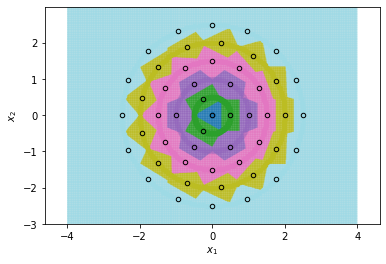

In [3]:
#%matplotlib notebook

from sklearn.utils import check_random_state, shuffle as util_shuffle
import numbers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from imblearn.under_sampling import *
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier as kNC
import numpy as np
num_classes=6
growth=0.5
X, y = make_k_circles(k=num_classes,n_samples=800,factor=None, c=growth, noise=.0)
#cnn = ClusterCentroids(sampling_strategy='all')#,random_state=0)
#n_samples=[1,3,6,9,12]
n_samples=[1,4,7,10,13,16]
n_samples=[1,3,6,12,13,16]
rot,min_rot_dist = get_rotations(n_samples)
print(rot)
print(min_rot_dist)
rot=[0,0,0,0,0,0]
for i in range(2,num_classes):
    rot[i]+=rot[i-1]#-(2*np.pi/(2*n_samples[i]))+(2*np.pi*np.gcd(n_samples[i-1],n_samples[i])/(2*n_samples[i-1]*n_samples[i]))
print(rot)
#print([0,0,2*np.pi/(4*6),1.5*np.pi/(6*9),2*1.5*np.pi/(9*12)])
#rot=[0,0,2*np.pi/(2*6)+2*np.pi/(4*6),2*np.pi/(2*6)+1.5*np.pi/(6*9),1.5*np.pi/(9*12)]
X_resampled, y_resampled = make_k_circles(k=num_classes, n_samples=n_samples, factor=None, c=growth, noise=0, rot =rot)#cnn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
#plt.title("Original space")
classes = [y==i for i in range(num_classes)]
# reds = y == 0
# blues = y == 1
# greens = y == 2
classes_resampled = [y_resampled==i for i in range(num_classes)]
# reds_resampled = y_resampled == 0
# blues_resampled = y_resampled == 1
# greens_resampled = y_resampled == 2

#plt.show()
distX=X_resampled
distY=y_resampled
clf=kNC(n_neighbors=1, weights="distance") #Can mess around with n_neighbors and weighting type, e.g. sum(n_samples)
clf.fit(distX,distY)
    #print(distX)
    #print(distY)

# Create color maps
if num_classes>20:
    cmap="gist_ncar"
else:
    cmap="tab20"
cmap_single = get_cmap(num_classes, cmap)
colors=cmap_single(range(num_classes))
#print(colors)
# create KNN classifier
# clf = SoftKNN(k=k)
#clf = neighbors.KNeighborsClassifier(min(n_neighbors, len(distX)), weights=weights)
# clf.fit(distX, distY)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
rad=num_classes*growth
x_min, x_max = -rad-1,rad+1
y_min, y_max = -rad,rad
size = (x_max-x_min)*(y_max-y_min)
desired_particles = 800000
h = (size/desired_particles)**0.5  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
# ax1.clear()
plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=0.1)
# if not mode =="true": 
#     ax1.scatter(distX[:, 0], distX[:, 1], c="black")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title("3-Class classification (k = %i)")
# for i in range(num_points):
#     axs[i].pie(dy[i], colors=colors)
for i in range(num_classes):
    plt.scatter(X[classes[i], 0], X[classes[i], 1], c=[colors[i]],
            s=20, alpha=1 if i != 2 else 0.2)#edgecolor='k')
    plt.scatter(X_resampled[classes_resampled[i], 0], X_resampled[classes_resampled[i], 1], c=[colors[i]],
            s=20,edgecolor='k')
# plt.scatter(X[reds, 0], X[reds, 1], c=[colors[0]],
#             s=20,alpha=0.2)# edgecolor='k')
# # km = KMeans(n_clusters=8)
# # km.fit(X[reds])
# # centers_red=km.cluster_centers_
# # plt.scatter(centers_red[:,0],centers_red[:,1],c="black")
# plt.scatter(X_resampled[reds_resampled, 0], X_resampled[reds_resampled, 1], c=[colors[0]],
#             s=20,edgecolor='k')

# plt.scatter(X[blues, 0], X[blues, 1], c=[colors[1]],
#             s=20, alpha=0.2)#edgecolor='k')
# plt.scatter(X_resampled[blues_resampled, 0], X_resampled[blues_resampled, 1], c=[colors[1]],
#             s=20,edgecolor='k')

# plt.scatter(X[greens, 0], X[greens, 1], c=[colors[2]],
#             s=20, alpha=0.2)#edgecolor='k')# km = KMeans(n_clusters=8)
# plt.scatter(X_resampled[greens_resampled, 0], X_resampled[greens_resampled, 1], c=[colors[2]],
#             s=20,edgecolor='k')
# km.fit(X[blues])
# centers_blue=km.cluster_centers_
# plt.scatter(centers_blue[:,0],centers_blue[:,1],c="black")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis('equal')

plt.savefig("knn_and_6_circles.png")
plt.show()

In [3]:
%matplotlib notebook

from sklearn.utils import check_random_state, shuffle as util_shuffle
import numbers
# from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from imblearn.under_sampling import *
from collections import Counter
# from sklearn.neighbors import KNeighborsClassifier as kNC
import numpy as np

num_classes=6
num_points=5
k=5
growth=0.5
X, y = make_k_circles(k=num_classes,n_samples=800,factor=None, c=growth, noise=.0)
# cnn = ClusterCentroids(sampling_strategy='all')#,random_state=0)
# n_samples=[1,4,6,9,12]
# n_samples=[1,4,7,10,13]
# rot,min_rot_dist = get_rotations(n_samples)
# print(rot)
# print(min_rot_dist)
# rot=[0,0,0,0,0]
# for i in range(2,num_classes):
#     rot[i]+=rot[i-1]#-(2*np.pi/(2*n_samples[i]))+(2*np.pi*np.gcd(n_samples[i-1],n_samples[i])/(2*n_samples[i-1]*n_samples[i]))
# print(rot)

# X_resampled, y_resampled = make_k_circles(k=num_classes, n_samples=n_samples, factor=None, c=growth, noise=0, rot =rot)#cnn.fit_resample(X, y)
max_ind=3*(num_classes-1)-1
dd=np.array([[0,0],[-max_ind,0],[max_ind,0], [0,max_ind], [0,-max_ind]])
dy=np.zeros((num_points,2*num_classes))

dy[0] = labels_2_points_n_classes(2*num_classes)


dy[1]=dy[0][::-1] 
print(dy[1])
#dy[0,4]*=1.01
dy[1,4]*=0.99
dy[2]=dy[1] 
dy[3]=dy[1]
dy[4]=dy[1]
#dy[0]*=2 This does something cool

#         half_ind = int((num_classes+1)/2)
half_ind = num_classes
dy[0][half_ind:]=np.zeros_like(dy[0][half_ind:])
dy[1][half_ind:]=np.zeros_like(dy[1][half_ind:])
dy[2][half_ind:]=np.zeros_like(dy[2][half_ind:])
dy[3][half_ind:]=np.zeros_like(dy[2][half_ind:])
dy[4][half_ind:]=np.zeros_like(dy[2][half_ind:])
# if normalize:
#     for j in range(len(dy)):
#         mag=sum(dy[j])
#         for i in range(len(dy[j])):
#             dy[j][i]/=mag
# print(sorted(Counter(y_resampled).items()))
#plt.title("Original space")
classes = [y==i for i in range(num_classes)]

# classes_resampled = [y_resampled==i for i in range(num_classes)]


#plt.show()
distX=dd
distY=dy
# clf=kNC(n_neighbors=1)
# clf.fit(distX,distY)
    #print(distX)
    #print(distY)

# Create color maps
if num_classes>20:
    cmap="gist_ncar"
else:
    cmap="tab20"
cmap_single = get_cmap(num_classes, cmap)
colors=cmap_single(range(num_classes))
#print(colors)
# create KNN classifier
clf = SoftKNN(k=k)
#clf = neighbors.KNeighborsClassifier(min(n_neighbors, len(distX)), weights=weights)
clf.fit(distX, distY)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
rad=num_classes*growth
x_min, x_max = -3,3
y_min, y_max = -4,4
size = (x_max-x_min)*(y_max-y_min)
desired_particles = 800000
h = (size/desired_particles)**0.5  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
# ax1.clear()
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
axs = [fig.add_subplot(num_points,2,2*(point+1)) for point in range(num_points)]
#axs = [fig.add_subplot(2,num_points,num_points+point+1) for point in range(num_points)]
ax1.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=0.05)
# if not mode =="true": 
#     ax1.scatter(distX[:, 0], distX[:, 1], c="black")
for i in range(num_classes):
    ax1.scatter(X[classes[i], 0], X[classes[i], 1], c=[colors[i]],
            s=20, alpha=1 if i != 2 else 0.2)#edgecolor='k')
ax1.set_xlim(xx.min(), xx.max())
ax1.set_ylim(yy.min(), yy.max())
#plt.title("3-Class classification (k = %i)")
ax1.set(xlabel="$x_1$", ylabel="$x_2$")
ax1.axis('scaled')
ax1.scatter(dd[:,0],dd[:,1], c="black", s=20,edgecolor='k')

for i in range(num_points):
    axs[i].pie(dy[i], colors=colors)
    axs[i].set(ylabel="({0}, {1})".format(dd[i][0],dd[i][1]))

plt.savefig("slapknn_and_6_circles_5points_zoomed_in.png")
plt.show()

NameError: name 'make_k_circles' is not defined

In [ ]:
import numpy as np
a=np.ones(3)
print(a)
print(a*3)

In [ ]:

def get_midpoint_dists(a,b):
    a_series = [a*i for i in range(b+1)] 
    a_midpoints =[a*(2*i+1)/2 for i in range(b)]
    b_series = [b*i for i in range(a+1)] 
    b_midpoints =[b*(2*i+1)/2 for i in range(a)]
#     plt.subplot(211)
#     plt.scatter(a_series, np.zeros_like(a_series), 
#             c='r', cmap="hot_r",vmin=-2)
#     plt.scatter(a_midpoints, np.zeros_like(a_midpoints), 
#             c='b', cmap="hot_r", vmin=-2)

#     plt.yticks([])
#     plt.subplot(212)
    
#     plt.scatter(b_series, np.zeros_like(b_series), 
#             c='r', cmap="hot_r",vmin=-5)
#     plt.scatter(b_midpoints, np.zeros_like(b_midpoints), 
#             c='b', cmap="hot_r", vmin=-5)

#     plt.yticks([])
#     plt.show()
    
    a_dists = [a_midpoint-min(b_series, key=lambda x:abs(x-a_midpoint)) for a_midpoint in a_midpoints]
    b_dists = [b_midpoint-min(a_series, key=lambda x:abs(x-b_midpoint)) for b_midpoint in b_midpoints]
    combined_dists=np.array(a_dists+b_dists)
    print("Inner Circle ({0}), Outer Circle ({1})".format(a,b))
    if np.any(np.isclose(0,combined_dists)):
        min_val=np.min(np.abs(combined_dists[np.nonzero(combined_dists)]))
        print("Rotation required of {0}".format(min_val/2))
        
    print("Distances from each midpoint of Inner Circle ({0}) to closest point of Outer Circle ({1})".format(a,b))
    print(a_dists)
    print("Distances from each midpoint of Outer Circle({1}) to closest point of Inner Circle ({0})".format(a,b))
    print(b_dists)
    print("\n")
        
    return
get_midpoint_dists(5,12)
get_midpoint_dists(5,20)
get_midpoint_dists(5,10)
get_midpoint_dists(5,12)
get_midpoint_dists(7,14)
get_midpoint_dists(7,16)


get_midpoint_dists(4,7)
get_midpoint_dists(6,7)
get_midpoint_dists(3,6)
get_midpoint_dists(6,9)
get_midpoint_dists(5,7)
get_midpoint_dists(3,9)
get_midpoint_dists(9,15)
get_midpoint_dists(15,21)
get_midpoint_dists(3,12)
get_midpoint_dists(3,24)
get_midpoint_dists(6,12)
get_midpoint_dists(6,16)
get_midpoint_dists(6,18)

get_midpoint_dists(4,6)
get_midpoint_dists(4,10)
get_midpoint_dists(4,12)
get_midpoint_dists(4,16)
get_midpoint_dists(4,18)
get_midpoint_dists(4,20)
get_midpoint_dists(4,24)
get_midpoint_dists(4,26)
get_midpoint_dists(4,28)

get_midpoint_dists(6,8)
get_midpoint_dists(6,10)
get_midpoint_dists(6,14)
get_midpoint_dists(6,16)
get_midpoint_dists(6,24)
get_midpoint_dists(6,30)
get_midpoint_dists(6,32)
get_midpoint_dists(6,42)
get_midpoint_dists(6,60)
get_midpoint_dists(10,150)
get_midpoint_dists(10,142)
get_midpoint_dists(10,22)
get_midpoint_dists(10,12)
get_midpoint_dists(10,14)
get_midpoint_dists(10,16)
get_midpoint_dists(10,18)
get_midpoint_dists(10,20)






#When even paired with odd, always requires rotation of gcd(a,b)/4
#When both odd, never requires rotation
#When both even, does not require rotation if b/a is odd, otherwise gcd(a,b/4)


In [ ]:
combined_dists=np.array([1,2]+[2,3])
np.min(np.abs(combined_dists[np.nonzero(combined_dists)]))

In [112]:
#T-SNE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print("Fetched")
random_state = check_random_state(0)
# permutation = random_state.permutation(X.shape[0])
# X = X[permutation]
# y = y[permutation]
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=6000, test_size=10000)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(len(X_train))
decomp = PCA(n_components=30, random_state=0)
reduced_data = decomp.fit_transform(X_train)
print("PCA complete")
model = TSNE(n_components=2, random_state=0, perplexity=40, init="pca", early_exaggeration=4, learning_rate=100)
tsne_data = model.fit_transform(reduced_data)




Fetched
6000
PCA complete


<IPython.core.display.Javascript object>


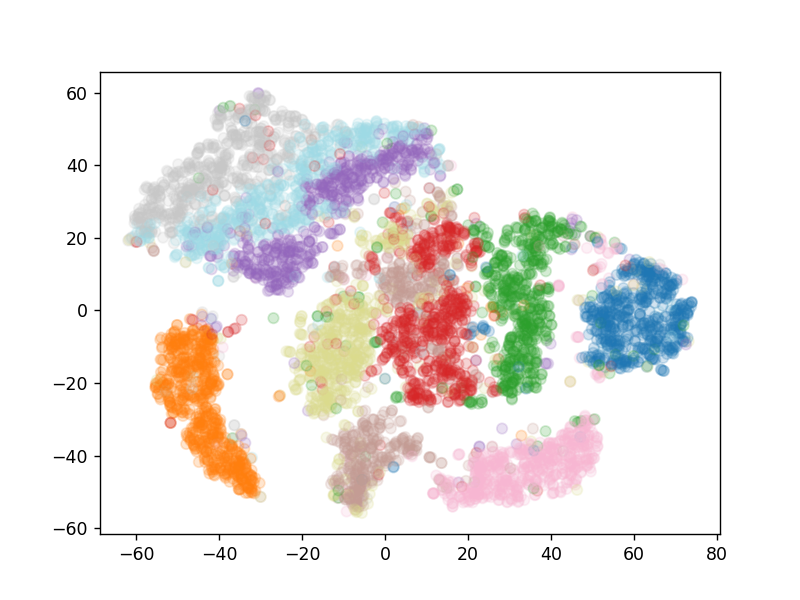

In [113]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
cmap_single = get_cmap(10, "tab20")
colors=cmap_single(range(10))
plt.scatter(tsne_data[:,0],tsne_data[:,1], c=[colors[int(i)] for i in y_train], alpha=0.2)
plt.show()

Fetched
20
177


<IPython.core.display.Javascript object>


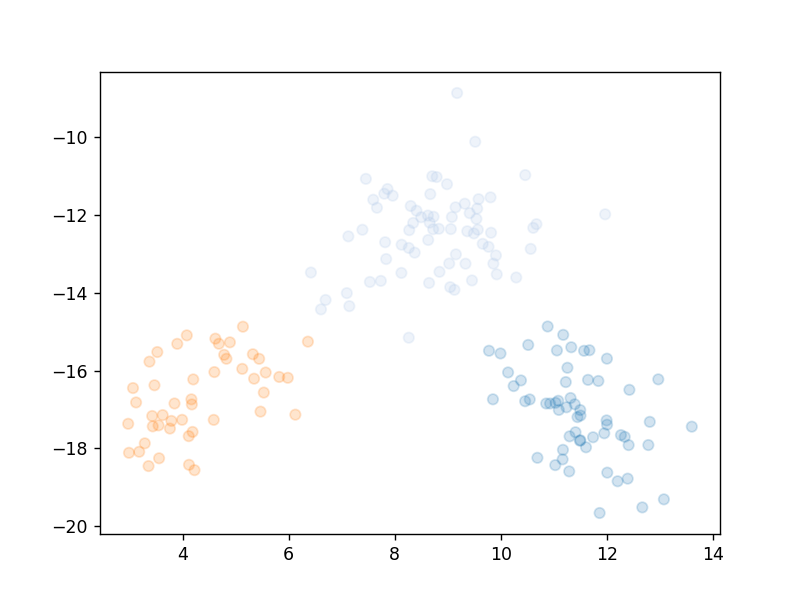

In [94]:
%matplotlib notebook
from collections import defaultdict 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
X, y = fetch_openml('wine', version=1, return_X_y=True)
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.utils import check_random_state, shuffle as util_shuffle

#X, y = make_blobs(n_samples =2001, n_features=2, centers=15, random_state=0)
print("Fetched")
random_state = check_random_state(0)
not_nan=[~np.any(row) for row in np.isnan(X)]
X=X[not_nan]
y = y[not_nan]
temp = defaultdict(lambda: len(temp)) 
y = [temp[ele] for ele in y] 
y=np.array(y)
num_classes = 20#len(temp.keys())
print(num_classes)
n_classes = y<num_classes
X=X[n_classes]
y=y[n_classes]
# permutation = random_state.permutation(X.shape[0])

# X = X[permutation]
# y = y[permutation]


X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=177, test_size=1)
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
print(len(X_train))
model = NCA(n_components=2, random_state=1)#, max_iter=100)#, perplexity=40)
tsne_data = model.fit_transform(X_train, y_train)
import numpy as np
import matplotlib.pyplot as plt
cmap_single = get_cmap(num_classes, "tab20")
colors=cmap_single(range(num_classes))
plt.scatter(tsne_data[:,0],tsne_data[:,1], c=[colors[int(i)] for i in y_train], alpha=0.2)
plt.show()

In [97]:
y[np.where(np.array(y)<10)]


TypeError: list indices must be integers or slices, not tuple

In [3]:
from palmerpenguins import load_penguins 
penguins = load_penguins()

100%|██████████| 8/8 [00:00<00:00, 8715.44it/s]

N: 2 M: 1 Valid: False


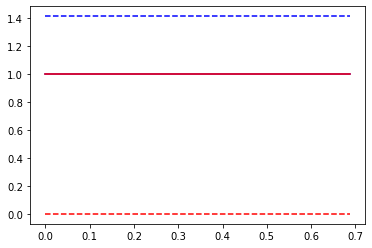

100%|██████████| 12/12 [00:00<00:00, 8145.60it/s]


N: 3 M: 1 Valid: True


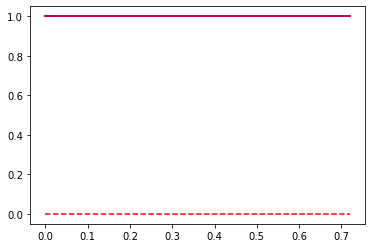

3


[1, 4, 7, 10, 13, 16, 19, 22, 26, 29, 32, 35, 38, 41]

In [1]:
#%matplotlib notebook
from tqdm import tqdm
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt
def d1(t,c,m,n,theta):
    dists = []
    for i in range(m):
        for j in range(n):
            dist = sqrt((t*c)**2 +((t+1)*c)**2 -2*t*(t+1)*(c**2)*np.cos((i*2*np.pi/m) - (j*2*np.pi/n) -np.pi/n - theta))
            dists.append(dist)
    return np.min(dists)
def d2(t,c,m,n,theta):
    dists = []
    for i in range(m):
        for j in range(n):
            dist = sqrt((t*c)**2 +((t+1)*c)**2 -2*t*(t+1)*(c**2)*np.cos((i*2*np.pi/m) - (j*2*np.pi/n) +np.pi/m - theta))
            dists.append(dist)
    return np.min(dists)


def check_configuration(m,n,t):
    db = sqrt(2*((t+1)*c)**2 - (2*((t+1)*c)**2)*np.cos(np.pi/n))
    #print(db)
    da = sqrt(2*(t*c)**2 - (2*(t*c)**2)*np.cos(np.pi/m))
    thetas = [i*np.pi/(m*n*16) for i in range(m*n*4)]
    bools = []
    d1s=[]
    d2s=[]
    for theta in tqdm(thetas):
            d1_temp=d1(t,c,m,n,theta)
            d2_temp=d2(t,c,m,n,theta)
            valid = d1_temp> db and d2_temp> da
            bools.append(valid)
            d1s.append(d1_temp)
            d2s.append(d2_temp)

        #valid_reg = np.array(thetas)[bools]
        #print (valid_reg)
    print ("N: {0} M: {1} Valid: {2}".format(n,m,np.any(bools)))
    #print(np.where(bools))
    plt.plot(thetas,d1s, "b")
    plt.plot([thetas[0],thetas[-1]],[db,db], "b--")
    plt.plot(thetas,d2s, "r")
    plt.plot([thetas[0],thetas[-1]],[da,da], "r--")
    plt.show()
    return np.any(bools)
def find_smallest_n(m,t, max_iters=100):
    for n in range(m+1,m+max_iters):
        if check_configuration(m,n,t):
            return n
    print("Failed to find valid N!")
    return -1
m=1
n= 5
t=0
c=1     
print(find_smallest_n(m,t))
    
[1,4,6,12,13,16,19,22,26,29,32,35,38,41]#Empirical method
[1,4,7,10,13,16,19,22,26,29,32,35,38,41]#Guaranteed method
    

In [2]:
np.pi*13

40.840704496667314

In [342]:
t=2
m=7
for n in range(12):
    if n/np.gcd(n,m)>np.pi/(m*np.arccos((1/(2*t*(t+1))) + np.cos(np.pi/m))): print(n)

3
4
5
6
8
9
10
11


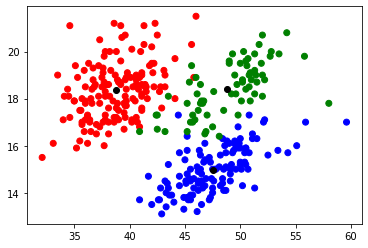

In [43]:
import palmerpenguins as pp
import matplotlib.pyplot as plt
from sklearn import neighbors, datasets
p=pp.load_penguins()
colors_dict = {}
for s,color in zip(list(set(p.species)),["red","blue","green"]):
    colors_dict[s]=color
adelie=penguins[penguins.species=="Adelie"]
adelie_cent=np.mean(adelie)
chin=penguins[penguins.species=="Chinstrap"]
chin_cent=np.mean(chin)
gentoo=penguins[penguins.species=="Gentoo"]
gentoo_cent=np.mean(gentoo)

plt.scatter(p.bill_length_mm, p.bill_depth_mm, c=[colors_dict[s] for s in p.species])
plt.scatter(adelie_cent.bill_length_mm, adelie_cent.bill_depth_mm, c="black")
plt.scatter(chin_cent.bill_length_mm, chin_cent.bill_depth_mm, c="black")
plt.scatter(gentoo_cent.bill_length_mm, gentoo_cent.bill_depth_mm, c="black")

plt.show()

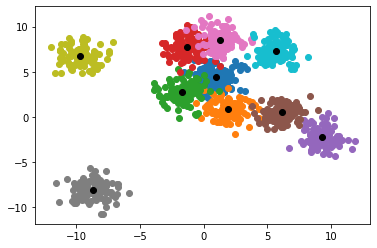

In [59]:
dat=datasets.make_blobs(n_samples=1000, centers=10, random_state=0)
centroids=[]
for i in range(10):
    temp=dat[0][dat[1]==i]
    x=[t[0] for t in temp]
    y=[t[1] for t in temp]
    centroid=np.array([np.mean(x),np.mean(y)])
    centroids.append(centroid)
    plt.scatter(x,y)
    plt.scatter(np.mean(x),np.mean(y),c="black")


In [60]:
mat=sklearn.neighbors.kneighbors_graph(np.array(centroids),2)
mat.toarray()

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])